# Transfer Learning for Pneumonia Detection by Chest X-Ray Images

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf
%matplotlib inline
from sklearn.metrics import confusion_matrix
from google.colab import drive, files

import cv2
import os
import glob

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, fbeta_score, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2

## Data

In [2]:
!pip install kaggle

In [3]:
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:16<00:00, 33.7MB/s]
100% 2.29G/2.29G [01:17<00:00, 32.0MB/s]


In [5]:
!unzip /content/chest-xray-pneumonia.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

In [6]:
INPUT_PATH = "/content/chest_xray"

# List the files in the input directory.
print(os.listdir(INPUT_PATH))

['chest_xray', 'test', '__MACOSX', 'train', 'val']


In [7]:
train_normal = Path(INPUT_PATH + '/train/NORMAL').glob('*.jpeg')
train_virus_pneumonia = Path(INPUT_PATH + '/train/PNEUMONIA').glob('*virus*.jpeg')
train_bacteria_pneumonia = Path(INPUT_PATH + '/train/PNEUMONIA').glob('*bacteria*.jpeg')

# ---------------------------------------------------------------
# Train data format in (img_path, label)
# Labels for [ the normal cases = 0 ] & [the pneumonia cases = 1]
# ---------------------------------------------------------------
normal_data = [(image, 0) for image in train_normal]
virus_pneumonia_data = [(image, 1) for image in train_virus_pneumonia]
bacteria_pneumonia_data = [(image, 2) for image in train_bacteria_pneumonia]

train_data = normal_data + virus_pneumonia_data + bacteria_pneumonia_data

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# Checking the dataframe...
train_data.head()

,image,label
0,/content/chest_xray/train/NORMAL/NORMAL2-IM-11...,0
1,/content/chest_xray/train/NORMAL/IM-0626-0001-...,0
2,/content/chest_xray/train/NORMAL/NORMAL2-IM-11...,0
3,/content/chest_xray/train/NORMAL/NORMAL2-IM-06...,0
4,/content/chest_xray/train/NORMAL/IM-0637-0001....,0


In [8]:
train_data.tail()

,image,label
5211,/content/chest_xray/train/PNEUMONIA/person13_b...,2
5212,/content/chest_xray/train/PNEUMONIA/person475_...,2
5213,/content/chest_xray/train/PNEUMONIA/person1670...,2
5214,/content/chest_xray/train/PNEUMONIA/person586_...,2
5215,/content/chest_xray/train/PNEUMONIA/person1518...,2


In [9]:
train_data = train_data.sample(frac=1., random_state=100).reset_index(drop=True)

# Checking the dataframe...
train_data.head(10)

,image,label
0,/content/chest_xray/train/PNEUMONIA/person77_b...,2
1,/content/chest_xray/train/PNEUMONIA/person1400...,2
2,/content/chest_xray/train/PNEUMONIA/person602_...,2
3,/content/chest_xray/train/PNEUMONIA/person1296...,1
4,/content/chest_xray/train/PNEUMONIA/person500_...,2
5,/content/chest_xray/train/PNEUMONIA/person591_...,2
6,/content/chest_xray/train/NORMAL/IM-0421-0001....,0
7,/content/chest_xray/train/PNEUMONIA/person543_...,2
8,/content/chest_xray/train/PNEUMONIA/person830_...,1
9,/content/chest_xray/train/PNEUMONIA/person1125...,1


In [10]:
print(train_data)

                                                  image  label
0     /content/chest_xray/train/PNEUMONIA/person77_b...      2
1     /content/chest_xray/train/PNEUMONIA/person1400...      2
2     /content/chest_xray/train/PNEUMONIA/person602_...      2
3     /content/chest_xray/train/PNEUMONIA/person1296...      1
4     /content/chest_xray/train/PNEUMONIA/person500_...      2
...                                                 ...    ...
5211  /content/chest_xray/train/PNEUMONIA/person1408...      2
5212  /content/chest_xray/train/PNEUMONIA/person1342...      1
5213  /content/chest_xray/train/NORMAL/IM-0369-0001....      0
5214  /content/chest_xray/train/NORMAL/NORMAL2-IM-09...      0
5215  /content/chest_xray/train/PNEUMONIA/person411_...      2

[5216 rows x 2 columns]


Total of Train Data :  5216 (0 : Normal; 1 : Bacterial Pneumonia; 2 : Viral Pneumonia)
2    2530
1    1345
0    1341
Name: label, dtype: int64


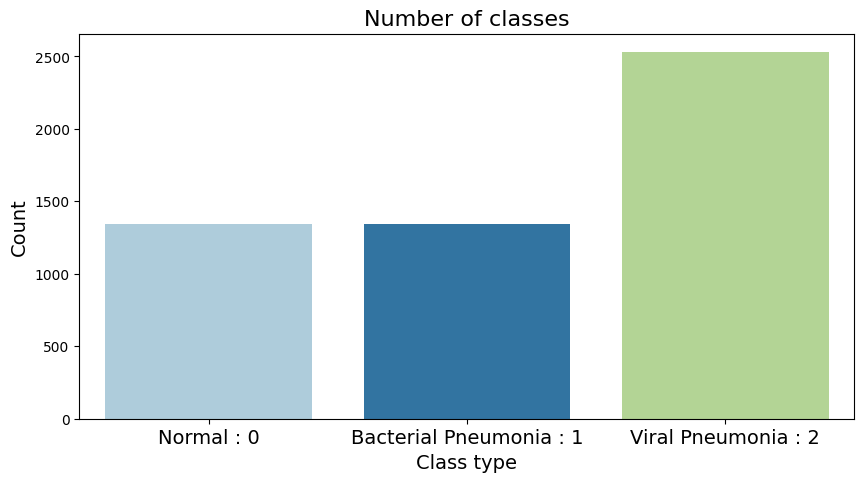

In [11]:
count_result = train_data['label'].value_counts()
print('Total of Train Data : ', len(train_data),
      '(0 : Normal; 1 : Bacterial Pneumonia; 2 : Viral Pneumonia)')
print(count_result)

# Plot the results
plt.figure(figsize=(10,5))
sns.countplot(x = 'label', data =  train_data,
              palette='Paired')
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)),
           ['Normal : 0', 'Bacterial Pneumonia : 1', 'Viral Pneumonia : 2'],
           fontsize=14)
plt.show()

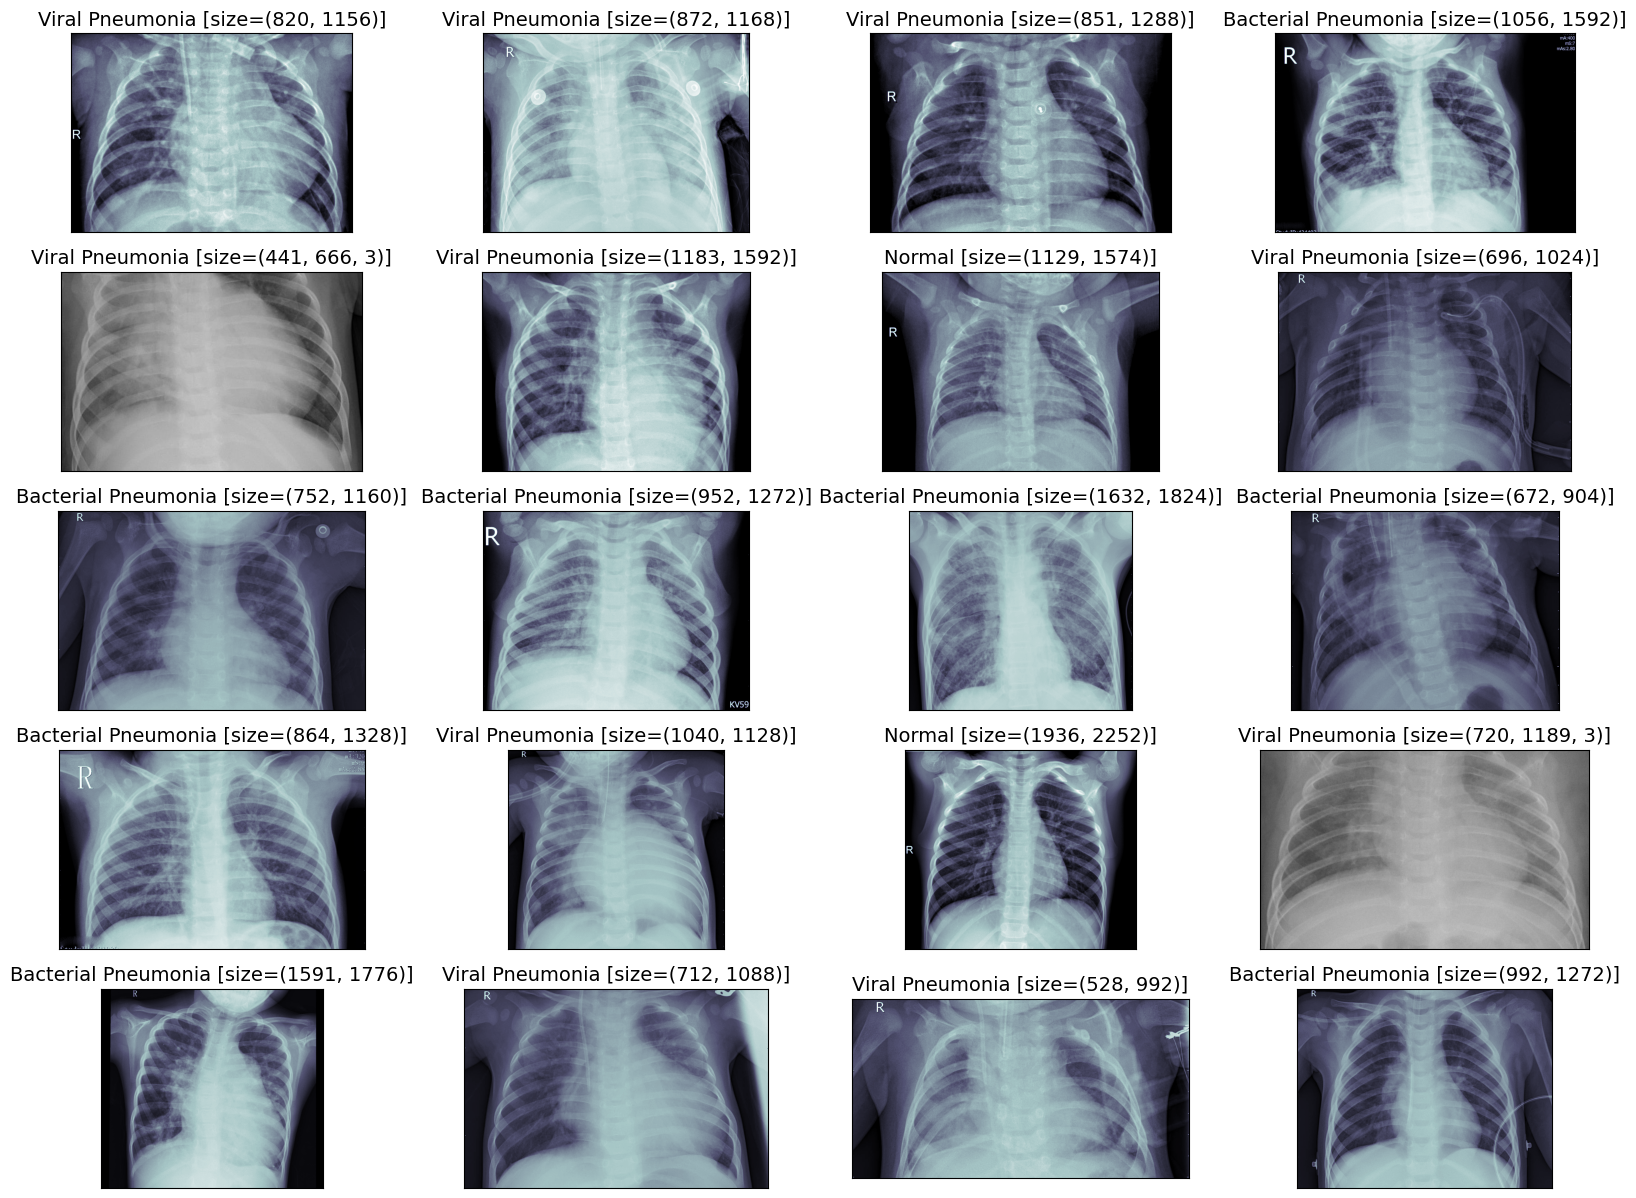

In [12]:
fig, ax = plt.subplots(5, 4, figsize=(20,15))
for i, axi in enumerate(ax.flat):
    image = imread(train_data.image[i])

    # Set title based on the label
    if train_data.label[i] == 0:
        class_title = 'Normal'
    elif train_data.label[i] == 1:
        class_title = 'Bacterial Pneumonia'
    else:
        class_title = 'Viral Pneumonia'

    axi.imshow(image, cmap='bone')
    axi.set_title(f'{class_title} [size={str(image.shape)}]',
                  fontsize=14)
    axi.set(xticks=[], yticks=[])

In [13]:
train_data.to_numpy().shape

(5216, 2)

In [14]:
def load_data(files_dir='/train'):
    # list of the paths of all the image files
    normal = Path(INPUT_PATH + files_dir + '/NORMAL').glob('*.jpeg')
    virus_pneumonia = Path(INPUT_PATH + files_dir + '/PNEUMONIA').glob('*virus*.jpeg')
    bacteria_pneumonia = Path(INPUT_PATH + files_dir + '/PNEUMONIA').glob('*bacteria*.jpeg')

    # --------------------------------------------------------------
    # Data-paths' format in (img_path, label)
    # labels : for [ Normal cases = 0 ] & [ Pneumonia cases = 1 ]
    # --------------------------------------------------------------
    normal_data = [(image, 0) for image in normal]
    virus_pneumonia_data = [(image, 1) for image in virus_pneumonia]
    bacteria_pneumonia_data = [(image, 2) for image in bacteria_pneumonia]

    image_data = normal_data + virus_pneumonia_data + bacteria_pneumonia_data

    # Get a pandas dataframe for the data paths
    image_data = pd.DataFrame(image_data, columns=['image', 'label'])

    # Shuffle the data
    image_data = image_data.sample(frac=1., random_state=100).reset_index(drop=True)

    # Importing both image & label datasets...
    x_images, y_labels = ([data_input(image_data.iloc[i][:]) for i in range(len(image_data))],
                         [image_data.iloc[i][1] for i in range(len(image_data))])

    # Convert the list into numpy arrays
    x_images = np.array(x_images)
    y_labels = np.array(y_labels)

    print("Total number of images: ", x_images.shape)
    print("Total number of labels: ", y_labels.shape)

    return x_images, y_labels

In [15]:
# ---------------------------------------------------------
#  1. Resizing all the images to 224x224 with 3 channels.
#  2. Then, normalize the pixel values.
# ---------------------------------------------------------
def data_input(dataset):
    # print(dataset.shape)
    for image_file in dataset:
        image = cv2.imread(str(image_file))
        image = cv2.resize(image, (224, 224))
        if image.shape[2] == 1:
            # np.dstack(): Stack arrays in sequence depth-wise
            #              (along third axis).
            # https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html
            image = np.dstack([image, image, image])

        # ----------------------------------------------------------
        # cv2.cvtColor(): The function converts an input image
        #                 from one color space to another.
        # [Ref.1]: "cvtColor - OpenCV Documentation"
        #     - https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
        # [Ref.2]: "Python计算机视觉编程- 第十章 OpenCV"
        #     - https://yongyuan.name/pcvwithpython/chapter10.html
        # ----------------------------------------------------------
        x_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalization
        x_image = x_image.astype(np.float32)/255.
        return x_image

In [16]:
# Import train dataset...
x_train, y_train = load_data(files_dir='/train')

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_train[0] shape", x_train[0].shape)
print("x_train[0]\n", x_train[0])
print("y_train", y_train)

Total number of images:  (5216, 224, 224, 3)
Total number of labels:  (5216,)
x_train shape (5216, 224, 224, 3)
y_train shape (5216,)
x_train[0] shape (224, 224, 3)
x_train[0]
 [[[0.07058824 0.07058824 0.07058824]
  [0.03921569 0.03921569 0.03921569]
  [0.05882353 0.05882353 0.05882353]
  ...
  [0.5058824  0.5058824  0.5058824 ]
  [0.52156866 0.52156866 0.52156866]
  [0.47058824 0.47058824 0.47058824]]

 [[0.07450981 0.07450981 0.07450981]
  [0.05490196 0.05490196 0.05490196]
  [0.0627451  0.0627451  0.0627451 ]
  ...
  [0.5294118  0.5294118  0.5294118 ]
  [0.49019608 0.49019608 0.49019608]
  [0.48235294 0.48235294 0.48235294]]

 [[0.09411765 0.09411765 0.09411765]
  [0.0627451  0.0627451  0.0627451 ]
  [0.09803922 0.09803922 0.09803922]
  ...
  [0.49803922 0.49803922 0.49803922]
  [0.4862745  0.4862745  0.4862745 ]
  [0.47843137 0.47843137 0.47843137]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.04705

In [17]:
# Import validation dataset...
x_val, y_val = load_data(files_dir='/val')

print("x_val shape", x_val.shape)
print("y_val shape", y_val.shape)
print("y_val", y_val)

Total number of images:  (16, 224, 224, 3)
Total number of labels:  (16,)
x_val shape (16, 224, 224, 3)
y_val shape (16,)
y_val [2 2 2 0 2 0 2 0 0 0 0 2 0 0 2 2]


In [18]:
x_test, y_test = load_data(files_dir='/test')

print(x_test.shape)
print(y_test.shape)

Total number of images:  (624, 224, 224, 3)
Total number of labels:  (624,)
(624, 224, 224, 3)
(624,)


In [19]:
count_result = pd.Series(y_test).value_counts()
print('Total of Test Data : ', len(y_test), '  (0 : Normal; 1 : Bacterial Pneumonia; 2 : Viral Pneumonia)')
print('------------------')
print(count_result)
print('------------------')
print('2 :  ', count_result[2]/sum(count_result))
print('1 :  ', count_result[1]/sum(count_result))
print('0 :  ', count_result[0]/sum(count_result))

Total of Test Data :  624   (0 : Normal; 1 : Bacterial Pneumonia; 2 : Viral Pneumonia)
------------------
2    242
0    234
1    148
dtype: int64
------------------
2 :   0.38782051282051283
1 :   0.23717948717948717
0 :   0.375


In [ ]:
y_test[:10]

array([2, 0, 2, 0, 1, 1, 2, 2, 1, 0])

## Tools


### data augmentation

In [20]:
def data_augm():
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.3,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.2,
        rotation_range=25,
        # horizontal_flip=True,  # Randomly flip inputs horizontally.
        # vertical_flip=True,  # Randomly flip inputs vertically.
        zoom_range=[0.85, 1.2], # Range for random zoom
        fill_mode='nearest',
        # brightness_range=[0.5, 1.5]
    )
    return datagen

### learning rate schedule

In [21]:
def lr_schedule(epoch):
  lr = 0.0001

  if epoch > 55:
    lr = 0.00001
  elif epoch > 35:
    lr = 0.00005
  elif epoch > 15:
    lr = 0.00007

  # print('learning rate: ', lr)

  return lr

### accuracy plot

In [22]:
def acc_plot(history_model, epochs):
  acc = history_model.history['accuracy']
  val_acc = history_model.history['val_accuracy']

  loss = history_model.history['loss']
  val_loss = history_model.history['val_loss']

  epochs_range = range(1, epochs + 1)
  # epochs_range = range(1, len(acc) + 1)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim(0, 1)
  plt.xticks(epochs_range)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylim(0, 2)
  plt.xticks(epochs_range)
  plt.title('Training and Validation Loss')

  return acc, val_acc, loss, val_loss
  plt.show()


In [23]:
def fine_tune_acc_plot(acc, val_acc, loss, val_loss, epochs):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0, 2])
  plt.plot([epochs-1, epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylim([0, 2])
  plt.plot([epochs-1, epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

### confusion matrix

In [24]:
def confusion_mat(y_test, y_pred):
  mat = confusion_matrix(y_test, y_pred)
  print(mat)

  plt.figure(figsize=(8,6))
  sns.heatmap(mat, square=False, annot=True, fmt ='d',
              cbar=True, annot_kws={"size": 16}, cmap='Blues')
  plt.title('0 : Normal   1 : Bacterial Pneumonia; 2 : Viral Pneumonia', fontsize = 20)
  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.xlabel('predicted value', fontsize = 20)
  plt.ylabel('true value', fontsize = 20)
  plt.show()
  return mat

### evaluate matrices

In [112]:
# Calculate Precision and Recall
def evaluate_matrices(y_test, y_pred):
  mat = confusion_mat(y_test, y_pred)

  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')

  print("\nTest Recall of the model \t = {:.4f}".format(np.mean(recall)))
  print("Test Precision of the model \t = {:.4f}".format(np.mean(precision)))
  print("Test Accuracy of the model \t = {:.4f}".format(accuracy))
  print("\nTest F1 score of the model \t = {:.4f}".format(np.mean(f1)))
  print("\nTest F2 score of the model \t = {:.4f}".format(np.mean(f2)))


## ResNet

In [ ]:
datagen = data_augm()

Using real-time data augmentation.


In [ ]:
base_model_resnet = tf.keras.applications.ResNet152V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    classes=3
)

### Feature Extraction

In [ ]:
base_model_resnet.trainable = False

In [ ]:
base_model_resnet.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [ ]:
x = base_model_resnet.output

# x = Conv2D(64, (5, 5), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (5, 5), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
# x = Dropout(0.2)(x)

# x = Conv2D(16, (1, 1), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(16, (1, 1), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
# x = Dropout(0.6)(x)

# x = Conv2D(128, (1, 1), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, (1, 1), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
# x = Dropout(0.25)(x)

# x = Conv2D(128, (1, 1), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(512, (5, 5), padding='same', activation='relu')(x)
# x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
# x = Dropout(0.25)

# ======================================================================

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
# x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
# x = Dropout(0.2)(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

# x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

output = Dense(3, activation='softmax')(x)

resnet = Model(inputs=base_model_resnet.input, outputs=output)

In [ ]:
resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [ ]:
len(resnet.trainable_variables)

36

### Train ResNet-152(V2) model

In [ ]:
epochs = 15
train_data_num = int(len(x_train) * 0.8)
print(train_data_num)

4172


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 1.2965448670146658, 1: 1.2926889714993803, 2: 0.6872200263504611}


In [ ]:
datagen.fit(x_train[:train_data_num])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-5,
    cooldown = 0,
    verbose = 1
)

resnet.compile(
    optimizer=RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_resnet = resnet.fit(
    datagen.flow(x_train[:train_data_num], y_train[:train_data_num]),
    epochs=epochs,
    validation_data=(x_train[train_data_num:], y_train[train_data_num:]),
    callbacks=[lr_scheduler],
    # steps_per_epoch=steps_per_epoch
    # ,
    class_weight=class_weights
)

Epoch 1/15
131/131 [==============================] - 65s 395ms/step - loss: 0.3640 - accuracy: 0.8440 - val_loss: 1.0731 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/15
131/131 [==============================] - 51s 387ms/step - loss: 0.2123 - accuracy: 0.9271 - val_loss: 1.0558 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/15
131/131 [==============================] - 51s 388ms/step - loss: 0.1927 - accuracy: 0.9331 - val_loss: 1.0097 - val_accuracy: 0.5316 - lr: 1.0000e-04
Epoch 4/15
131/131 [==============================] - 50s 383ms/step - loss: 0.1834 - accuracy: 0.9384 - val_loss: 0.7838 - val_accuracy: 0.8343 - lr: 1.0000e-04
Epoch 5/15
131/131 [==============================] - 52s 393ms/step - loss: 0.1764 - accuracy: 0.9415 - val_loss: 0.5072 - val_accuracy: 0.8113 - lr: 1.0000e-04
Epoch 6/15
131/131 [==============================] - 51s 391ms/step - loss: 0.1703 - accuracy: 0.9487 - val_loss: 0.7736 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 7/15
131/131 [========

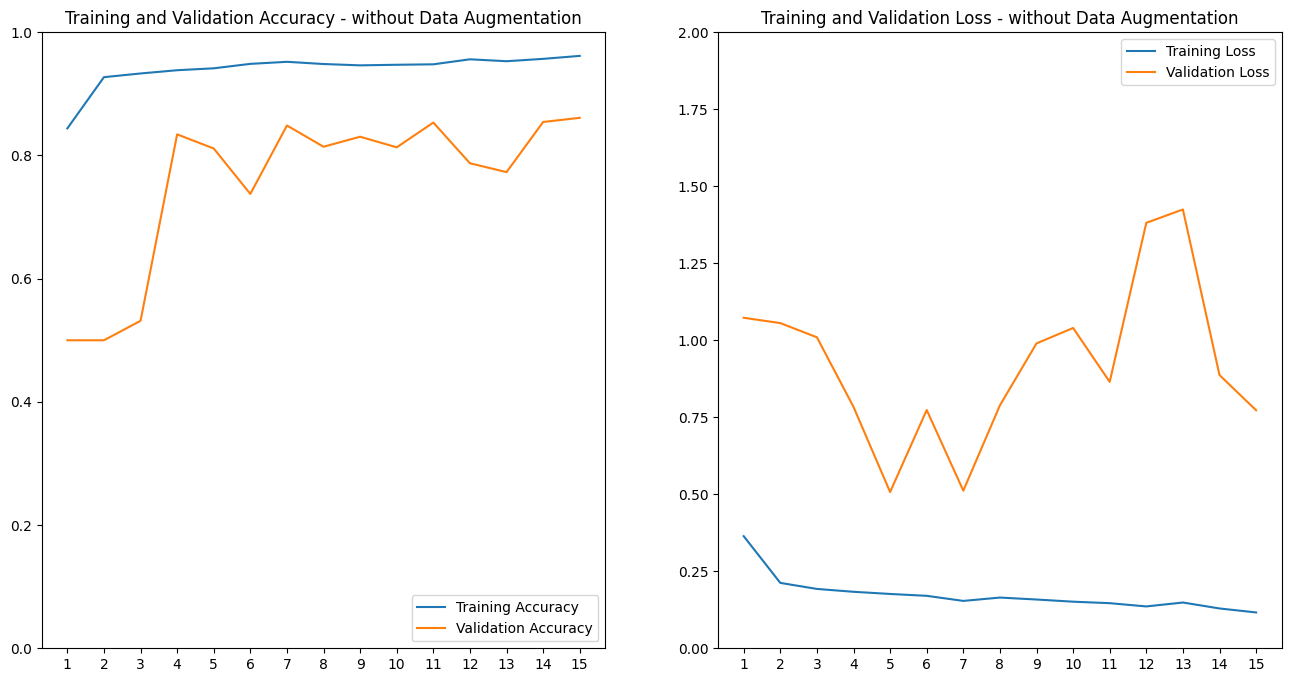

In [ ]:
acc, val_acc, loss, val_loss = acc_plot(history_resnet, epochs)

### Fine Tuning

In [ ]:
base_model_resnet.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model_resnet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 484

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_resnet.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  564


In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

resnet.compile(
    optimizer=RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [ ]:
len(resnet.trainable_variables)

190

In [ ]:
fine_tune_epochs = 100
total_epochs =  epochs + fine_tune_epochs

batch_size = 64
steps_per_epoch = len(x_train[:train_data_num]) // batch_size
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# tf.keras.backend.clear_session()

history_fine = resnet.fit(
    datagen.flow(x_train[:train_data_num], y_train[:train_data_num]),
    epochs=total_epochs,
    initial_epoch=history_resnet.epoch[-1],
    validation_data=(x_train[train_data_num:], y_train[train_data_num:]),
    callbacks=[early_stopping, lr_scheduler],
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights
)

Epoch 15/115
65/65 [==============================] - 49s 515ms/step - loss: 0.1494 - accuracy: 0.9505 - val_loss: 0.9286 - val_accuracy: 0.8381 - lr: 1.0000e-04
Epoch 16/115
65/65 [==============================] - 30s 452ms/step - loss: 0.1410 - accuracy: 0.9456 - val_loss: 1.0088 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 17/115
65/65 [==============================] - 30s 465ms/step - loss: 0.1261 - accuracy: 0.9607 - val_loss: 0.5705 - val_accuracy: 0.8544 - lr: 5.0000e-06
Epoch 18/115
65/65 [==============================] - 30s 464ms/step - loss: 0.1008 - accuracy: 0.9611 - val_loss: 0.5061 - val_accuracy: 0.8467 - lr: 5.0000e-06
Epoch 19/115
65/65 [==============================] - 29s 447ms/step - loss: 0.0851 - accuracy: 0.9694 - val_loss: 0.5388 - val_accuracy: 0.8506 - lr: 5.0000e-06
Epoch 20/115
65/65 [==============================] - 30s 455ms/step - loss: 0.0936 - accuracy: 0.9704 - val_loss: 0.5049 - val_accuracy: 0.8515 - lr: 5.0000e-06
Epoch 21/115
65/65 [========

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

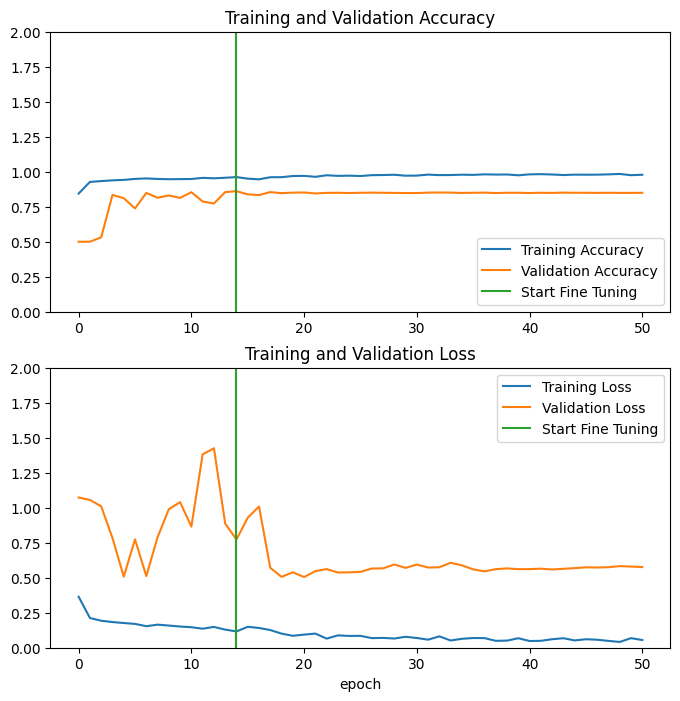

In [ ]:
fine_tune_acc_plot(acc, val_acc, loss, val_loss, epochs=epochs)

In [ ]:
test_loss, test_acc = resnet.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

20/20 [==============================] - 5s 237ms/step - loss: 0.6352 - accuracy: 0.8462
Test loss: 0.6351751685142517
Test accuracy: 0.8461538553237915


In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/DL/HW/chest_xray')

resnet.save("resnet_152v2_.keras")

In [ ]:
# 載入模型
drive.mount('/content/drive')
resnet_88 = load_model('/content/drive/MyDrive/DL/HW/chest_xray/resnet_152v2_88_3.keras')

# 使用載入的模型進行預測等操作
preds = resnet_88.predict(x_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
20/20 [==============================] - 7s 251ms/step


In [ ]:
test_loss, test_acc = resnet_88.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

20/20 [==============================] - 9s 249ms/step - loss: 0.5097 - accuracy: 0.8830
Test loss: 0.5096997618675232
Test accuracy: 0.8830128312110901


In [ ]:
preds.shape

(624, 3)

In [ ]:
# y_pred = np.where(preds > 0.5, 1, 0)
y_pred = np.argmax(preds, axis=1)

print(' y_pred = ', np.array(y_pred[:10]))
print(' y_test = ', y_test[:10])

 y_pred =  [2 0 2 0 1 2 2 2 1 0]
 y_test =  [2 0 2 0 1 1 2 2 1 0]


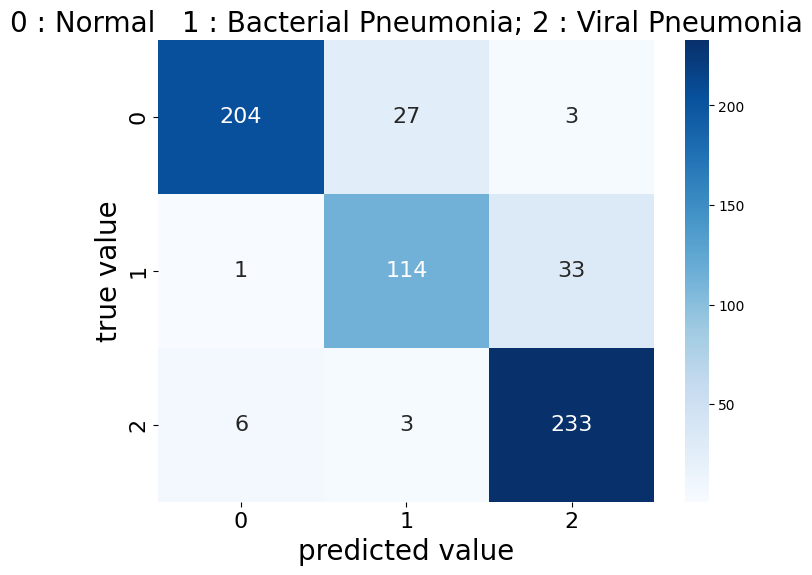


Test Recall of the model 	 = 0.8683
Test Precision of the model 	 = 0.8749
Test Accuracy of the model 	 = 0.8830

Test F1 score of the model 	 = 0.8699

Test F2 score of the model 	 = 0.8685


In [ ]:
evaluate_matrices(y_test, y_pred)

## InceptionV3

In [26]:
datagen = data_augm()

Using real-time data augmentation.


In [49]:
base_model_inception = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    classes=3
)

### Feature Extraction

In [50]:
base_model_inception.trainable = False

In [51]:
base_model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_104 (B  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalizati

In [88]:
x = base_model_inception.output

x = Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(x)

output = Dense(3, activation='softmax')(x)

inception = Model(inputs=base_model_inception.input, outputs=output)

In [89]:
inception.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_104 (B  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_10

In [ ]:
len(inception.trainable_variables)

50

### Train InceptionV3 model

In [90]:
epochs_i = 13
train_data_num = int(len(x_train) * 0.8)

In [55]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 1.2965448670146658, 1: 1.2926889714993803, 2: 0.6872200263504611}


In [91]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

inception.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_inception = inception.fit(
   datagen.flow(x_train[:train_data_num], y_train[:train_data_num]),
   epochs=epochs_i,
   validation_data=(x_train[train_data_num:], y_train[train_data_num:]),
   callbacks=[lr_scheduler],
   class_weight=class_weights
)

Epoch 1/13
131/131 [==============================] - 68s 326ms/step - loss: 1.1460 - accuracy: 0.4418 - val_loss: 1.0323 - val_accuracy: 0.6073 - lr: 1.0000e-04
Epoch 2/13
131/131 [==============================] - 44s 331ms/step - loss: 0.8097 - accuracy: 0.6721 - val_loss: 0.6688 - val_accuracy: 0.7883 - lr: 1.0000e-04
Epoch 3/13
131/131 [==============================] - 44s 335ms/step - loss: 0.7448 - accuracy: 0.7291 - val_loss: 0.5854 - val_accuracy: 0.8151 - lr: 1.0000e-04
Epoch 4/13
131/131 [==============================] - 44s 334ms/step - loss: 0.6846 - accuracy: 0.7605 - val_loss: 0.5911 - val_accuracy: 0.8123 - lr: 1.0000e-04
Epoch 5/13
131/131 [==============================] - 45s 340ms/step - loss: 0.6412 - accuracy: 0.7800 - val_loss: 0.6341 - val_accuracy: 0.8084 - lr: 1.0000e-04
Epoch 6/13
131/131 [==============================] - 43s 330ms/step - loss: 0.6213 - accuracy: 0.7852 - val_loss: 0.7397 - val_accuracy: 0.7960 - lr: 1.0000e-04
Epoch 7/13
131/131 [========

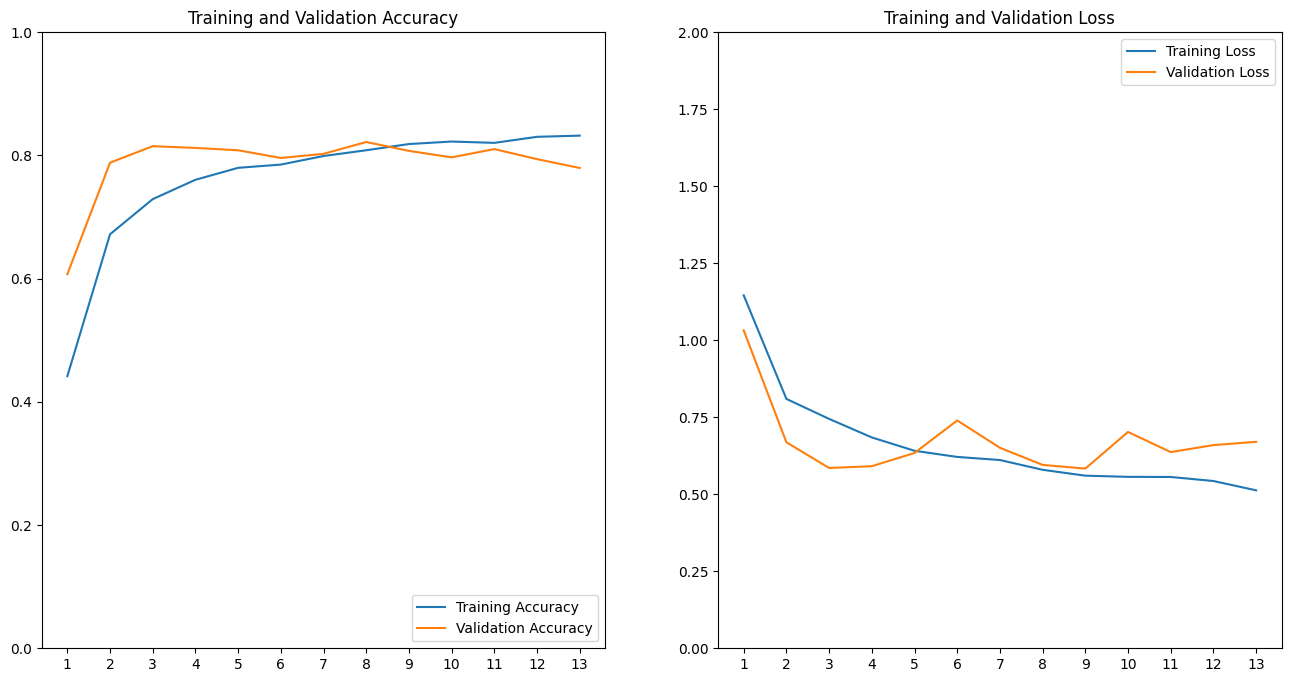

In [92]:
acc_inception, val_acc_inception, loss_inception, val_loss_inception = acc_plot(history_inception, epochs_i)

### Fine Tuning

In [93]:
base_model_inception.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model_inception.layers))

Number of layers in the base model:  311


In [94]:
# Fine-tune from this layer onwards
fine_tune_at = 306

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_inception.layers[:fine_tune_at]:
  layer.trainable =  False

In [98]:
inception.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [99]:
inception.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_104 (B  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_10

In [ ]:
len(inception.trainable_variables)

102

In [100]:
batch_size = 64

fine_tune_epochs_i = 100
total_epochs_i =  epochs_i + fine_tune_epochs_i
steps_per_epoch = len(x_train[:train_data_num]) // batch_size
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=15, restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

history_fine_inception = inception.fit(
    x=x_train[:train_data_num],
    y=y_train[:train_data_num],
    epochs=total_epochs_i,
    initial_epoch=history_inception.epoch[-1],
    validation_data=(x_train[train_data_num:], y_train[train_data_num:]),
    callbacks=[lr_scheduler, early_stopping, plateau],
    # steps_per_epoch=steps_per_epoch,
    class_weight=class_weights
)

Epoch 13/113
131/131 [==============================] - 24s 128ms/step - loss: 0.4049 - accuracy: 0.8909 - val_loss: 0.5549 - val_accuracy: 0.8410 - lr: 1.0000e-04
Epoch 14/113
131/131 [==============================] - 15s 115ms/step - loss: 0.3658 - accuracy: 0.9017 - val_loss: 0.5863 - val_accuracy: 0.8324 - lr: 1.0000e-04
Epoch 15/113
131/131 [==============================] - 15s 113ms/step - loss: 0.3473 - accuracy: 0.9166 - val_loss: 0.5664 - val_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 16/113
131/131 [==============================] - 15s 112ms/step - loss: 0.3296 - accuracy: 0.9240 - val_loss: 0.6747 - val_accuracy: 0.8209 - lr: 1.0000e-04
Epoch 17/113
130/131 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.9329
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.4000000373926015e-05.
131/131 [==============================] - 15s 112ms/step - loss: 0.3027 - accuracy: 0.9331 - val_loss: 0.6189 - val_accuracy: 0.8362 - lr: 7.0000e-05
Epoch 18/113
131/

In [101]:
acc_inception += history_fine_inception.history['accuracy']
val_acc_inception += history_fine_inception.history['val_accuracy']

loss_inception += history_fine_inception.history['loss']
val_loss_inception += history_fine_inception.history['val_loss']

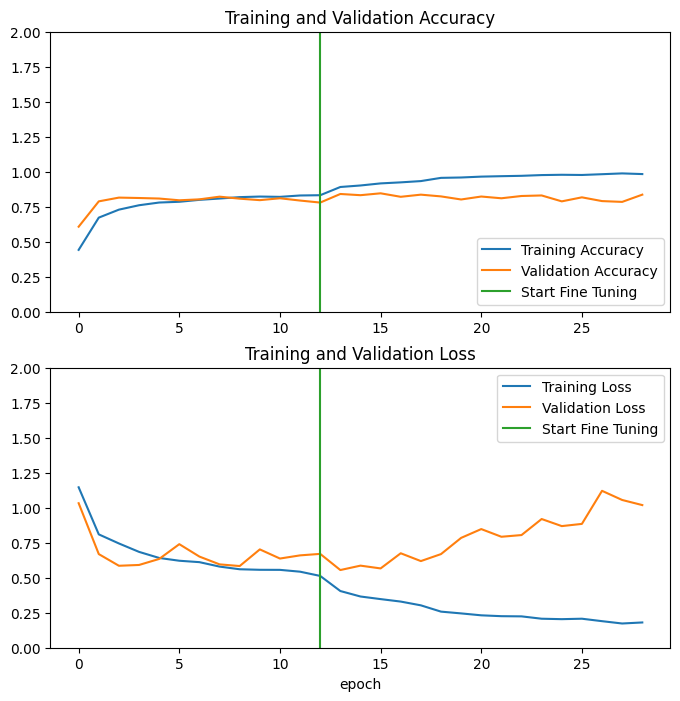

In [102]:
fine_tune_acc_plot(acc_inception, val_acc_inception,
                   loss_inception, val_loss_inception, epochs_i)

In [103]:
test_loss_i, test_acc_i = inception.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {test_loss_i}')
print(f'Test accuracy: {test_acc_i}')

20/20 [==============================] - 2s 84ms/step - loss: 0.8260 - accuracy: 0.8141
Test loss: 0.825962245464325
Test accuracy: 0.8141025900840759


In [104]:
preds_i = inception.predict(x_test)

20/20 [==============================] - 3s 76ms/step


In [105]:
preds_i.shape

(624, 3)

In [106]:
y_pred_i = np.argmax(preds_i, axis=1)

print(' y_pred = ', np.array(y_pred_i[:10]))
print(' y_test = ', y_test[:10])

 y_pred =  [2 0 2 0 1 2 2 2 1 0]
 y_test =  [2 0 2 0 1 1 2 2 1 0]


[[170  45  19]
 [  1 103  44]
 [  2   5 235]]


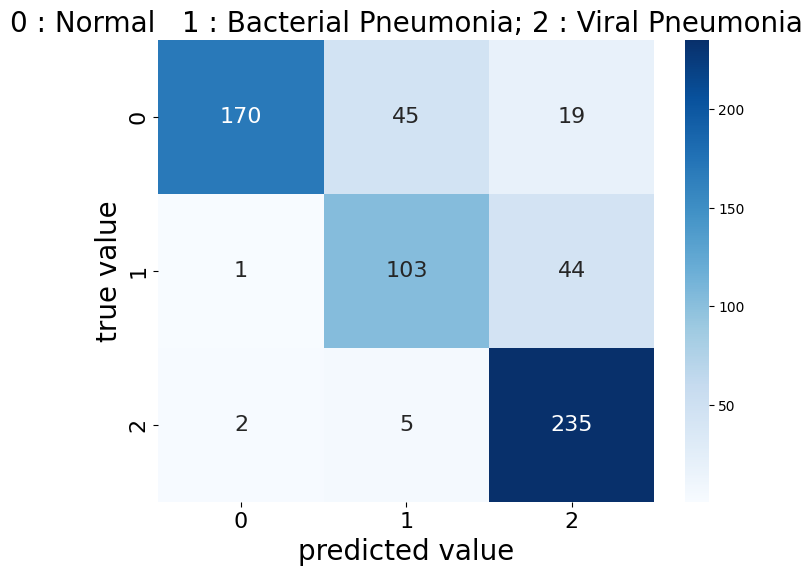


Test Recall of the model 	 = 0.8141
Test Precision of the model 	 = 0.8340
Test Accuracy of the model 	 = 0.8141

Test F1 score of the model 	 = 0.8131

Test F2 score of the model 	 = 0.8113


In [113]:
evaluate_matrices(y_test, y_pred_i)

## Conclusion

1.   ResNet152V2：

* 實際上是正常，但被預測為Bacterial，以及實際上是Bacterial，但被預測為Viral的數量分別為27和33，相對於其他分類錯誤的數量偏多。
* Recall大約為87%，代表在所有正樣本當中，預測正樣本的比例為87%
* Precision大約為87.5%，代表所有預測為正樣本中，有87.5%為正樣本
* F1 score大約為87%，是Recall與Precision的調和平均數
* F2 score大約為87%，注重Recall

2.   InceptionV3：
* 實際上是正常，但被預測為Bacterial、實際上是正常，但被預測為Viral，以及實際上是Bacterial，但被預測為Viral的數量分別為45、19和44，相對於其他分類錯誤的數量偏多。
* Recall大約為81%
* Precision大約為83%
* F1 score大約為81%
* F2 score大約為81%

3.   比較ResNet152V2和InceptionV3
* ResNet用的層數比Inception還要更多更複雜，在驗證資料集的表現相對比較穩定，且準確率也比較高。
* Inception在訓練過程中，驗證資料集的準確率及損失在fine tune時很容易上下跳動，不容易收斂。
* 有試過將相同的模型架構（接在pre-trained model後面）用於兩個模型，但是InceptionV3的效果很不好，訓練過程更不穩定。

4. 提升準確率可能的方法：驗證資料集的準確率目前最高只試到86%左右，若要將測試資料集的準確率提升到95%以上需要再多試不同的learning rate（調整learning rate schedule）、增加更多模型的層數或是多試其他data augmentation的組合。
* 經過數次的fine tune，我認為這兩個模型不管是取pre-trained model的前中後層差異都沒有很大。